In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install -U "transformers>=4.31" datasets scikit-learn accelerate

In [2]:
import os
os.environ["WANDB_DISABLED"] = "true"     # tắt hẳn
os.environ["WANDB_MODE"]     = "disabled"
os.environ["WANDB_SILENT"]   = "true"
os.environ["WANDB_API_KEY"]  = ""         # đề phòng code nào đó gọi login()
os.environ["HF_HUB_DISABLE_TELEMETRY"] = "1"


In [3]:
import json, random, inspect
from typing import List, Dict
import numpy as np
import pandas as pd
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer
)

print("Transformers version:", __import__("transformers").__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ==== CONFIG ====
LABELS     = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
MODEL_NAME = "xlm-roberta-base"         # có thể đổi sang "vinai/phobert-base" nếu bạn đã word-seg
TRAIN_CSV  = "/content/drive/MyDrive/Colab Notebooks/dataset_toxic/train_vn.csv"              # đường dẫn data
OUT_DIR    = "/content/drive/MyDrive/Colab Notebooks/dataset_toxic/model_toxic_vn"     # nơi lưu model + thresholds
MAX_LEN    = 256
EPOCHS     = 3
LR         = 2e-5
BS_TRAIN   = 16
BS_EVAL    = 32
SEED       = 42

os.makedirs(OUT_DIR, exist_ok=True)
def set_seed(s=SEED):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
set_seed()

# =========================
# 3) ĐỌC DỮ LIỆU
# =========================
def load_csv_safely(path):
    last = None
    for enc in ["utf-8","utf-8-sig","latin1"]:
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception as e:
            last = e
    raise RuntimeError(f"Không thể đọc CSV: {path}. Lỗi cuối: {last}")

df = load_csv_safely(TRAIN_CSV)
assert "comment_text" in df.columns, "Thiếu cột 'comment_text'"
for c in LABELS: assert c in df.columns, f"Thiếu cột nhãn {c}"

df["comment_text"] = df["comment_text"].fillna("").astype(str).str.strip()
for c in LABELS: df[c] = df[c].fillna(0).astype(int)

df = df.sample(frac=1.0, random_state=SEED).reset_index(drop=True)
print("Data shape:", df.shape)
try:
    from IPython.display import display
    display(df.head(3))
except:
    print(df.head(3))

Transformers version: 4.57.1
Device: cuda
Data shape: (3677, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,vi_clean_00881,Thật ra thấy chủ đề này gợi ý nhiều ý tưởng. C...,0,0,0,0,0,0
1,vi_clean_00491,Nói ngắn gọn thì thấy bảng số liệu nên có phần...,0,0,0,0,0,0
2,toxic_text_16,"đụ má ngu như bò, óc lồn",1,1,1,0,1,0


In [4]:
from transformers import AutoTokenizer, DataCollatorWithPadding
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

from collections import Counter
test_size = 0.1
y_signature = df[LABELS].astype(int).astype(str).agg("".join, axis=1)
min_count_for_strata = max(2, int(np.ceil(1 / test_size)))  # thường là 10

sig_counts = Counter(y_signature)
y_sig_safe = y_signature.where(y_signature.map(sig_counts) >= min_count_for_strata, other="OTHER")
use_stratify = y_sig_safe if y_sig_safe.nunique() > 1 else None

train_df, val_df = train_test_split(
    df, test_size=test_size, random_state=SEED, shuffle=True, stratify=use_stratify
)

train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds   = Dataset.from_pandas(val_df.reset_index(drop=True))

def encode_with_labels(batch):
    enc = tok(batch["comment_text"], truncation=True, max_length=MAX_LEN)
    enc["labels"] = [[int(batch[c][i]) for c in LABELS] for i in range(len(batch["comment_text"]))]
    return enc

train_ds = train_ds.map(encode_with_labels, batched=True, remove_columns=list(train_df.columns))
val_ds   = val_ds.map(encode_with_labels,   batched=True, remove_columns=list(val_df.columns))

# (tùy chọn) Shuffle thêm ở cấp HF Dataset
train_ds = train_ds.shuffle(seed=SEED)

train_ds = train_ds.with_format("torch")
val_ds   = val_ds.with_format("torch")

print("train_ds columns:", train_ds.column_names)
print("val_ds columns:",   val_ds.column_names)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/3309 [00:00<?, ? examples/s]

Map:   0%|          | 0/368 [00:00<?, ? examples/s]

train_ds columns: ['input_ids', 'attention_mask', 'labels']
val_ds columns: ['input_ids', 'attention_mask', 'labels']


In [5]:
class MyCollator:
    def __init__(self, tokenizer):
        self.tok = tokenizer
    def __call__(self, features):
        import torch
        labels = torch.stack([f["labels"] for f in features])   # (B, 6)
        feats  = [{k:v for k,v in f.items() if k != "labels"} for f in features]
        batch  = self.tok.pad(feats, return_tensors="pt")
        batch["labels"] = labels
        return batch

collator = MyCollator(tok)

In [6]:
def build_args_compat(out_dir, lr, bs_train, bs_eval, epochs):
    base = dict(
        output_dir=out_dir,
        learning_rate=lr,
        per_device_train_batch_size=bs_train,
        per_device_eval_batch_size=bs_eval,
        num_train_epochs=epochs,
        weight_decay=0.01,
        logging_steps=50,
        fp16=torch.cuda.is_available(),
        seed=SEED, data_seed=SEED, group_by_length=False,
        warmup_ratio=0.1,
        lr_scheduler_type="cosine",
        gradient_accumulation_steps=2,
        gradient_checkpointing=True,
        max_grad_norm=1.0,
        save_total_limit=2,
        report_to="none",
    )
    allowed = set(inspect.signature(TrainingArguments.__init__).parameters.keys())
    def mk(d): return TrainingArguments(**{k:v for k,v in d.items() if k in allowed})

    if "evaluation_strategy" in allowed and "save_strategy" in allowed:
        return mk({
            **base,
           "evaluation_strategy": "steps",
            "save_strategy": "steps",
            "eval_steps": 200,                   # hoặc ~1/5 epoch
            "save_steps": 200,
            "load_best_model_at_end": True,
            "metric_for_best_model": "F1_micro",
            "greater_is_better": True,
        })

    legacy = {}
    if "do_eval" in allowed:    legacy["do_eval"] = True
    if "eval_steps" in allowed: legacy["eval_steps"] = 500
    if "save_steps" in allowed: legacy["save_steps"] = 500
    return mk({**base, **legacy})

args = build_args_compat(OUT_DIR, LR, BS_TRAIN, BS_EVAL, EPOCHS)

In [7]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=len(LABELS), problem_type="multi_label_classification"
).to(device)

# pos_weight cho mất cân bằng
pos = train_df[LABELS].sum(0).values
neg = len(train_df) - pos
pos_weight = torch.tensor(neg / np.clip(pos, 1, None), dtype=torch.float)

class WeightedMultiLabelTrainer(Trainer):
    def __init__(self, pos_weight, label_smoothing=0.05, **kwargs):
        super().__init__(**kwargs)
        self.pos_weight = pos_weight
        self.label_smoothing = label_smoothing

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels  = inputs.pop("labels").float()
        if self.label_smoothing > 0:
            eps = self.label_smoothing
            labels = labels * (1 - eps) + (1 - labels) * eps  # 1→1-eps, 0→eps

        outputs = model(**inputs)
        logits  = outputs.logits
        loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight.to(model.device))
        loss    = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

# compute_metrics tương thích (nhận EvalPrediction hoặc tuple)
def compute_metrics(eval_pred):
    try:
        logits = eval_pred.predictions
        labels = eval_pred.label_ids
    except Exception:
        logits, labels = eval_pred
    probs = 1/(1+np.exp(-logits))
    preds = (probs >= 0.5).astype(int)
    out = {
        "F1_micro": f1_score(labels, preds, average="micro", zero_division=0),
        "F1_macro": f1_score(labels, preds, average="macro", zero_division=0),
    }
    for i, c in enumerate(LABELS):
        out[f"F1_{c}"] = f1_score(labels[:, i], preds[:, i], zero_division=0)
    return out

trainer = WeightedMultiLabelTrainer(
    pos_weight=pos_weight,
    model=model, args=args,
    train_dataset=train_ds, eval_dataset=val_ds,
    tokenizer=tok, data_collator=collator,
    compute_metrics=compute_metrics
)

# Sanity check batch
b0 = next(iter(trainer.get_train_dataloader()))
print("trainer batch keys:", b0.keys())
print("labels shape:", b0["labels"].shape)


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-55563749.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedMultiLabelTrainer.__init__`. Use `processing_class` instead.
  super().__init__(**kwargs)
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


trainer batch keys: KeysView({'input_ids': tensor([[     0,  66863,   4310,  ...,      1,      1,      1],
        [     0,     44,    856,  ...,      5,     44,      2],
        [     0,   9031,   1617,  ...,      1,      1,      1],
        ...,
        [     0,  14532,  31462,  ...,      1,      1,      1],
        [     0, 106792,  56629,  ...,      1,      1,      1],
        [     0, 151718,   2872,  ...,      1,      1,      1]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'), 'labels': tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0],
        [1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 

In [11]:
trainer.train()

Step,Training Loss
50,1.525400
100,1.273400
150,1.184600
200,1.142000
250,1.120100
300,1.113200


TrainOutput(global_step=312, training_loss=1.2222309173681798, metrics={'train_runtime': 229.7918, 'train_samples_per_second': 43.2, 'train_steps_per_second': 1.358, 'total_flos': 444437769744756.0, 'train_loss': 1.2222309173681798, 'epoch': 3.0})

In [12]:
import os, json, numpy as np
from sklearn.metrics import f1_score, classification_report, precision_recall_curve

model.eval()

with torch.no_grad():
    pred_train = trainer.predict(train_ds)
    pred_val   = trainer.predict(val_ds)

logits_train = pred_train.predictions
logits_val   = pred_val.predictions

y_train = train_df[LABELS].values
y_val   = val_df[LABELS].values

# sigmoid
probs_train = 1 / (1 + np.exp(-logits_train))
probs_val   = 1 / (1 + np.exp(-logits_val))

TARGET_P = {
    "toxic": 0.8,
    "severe_toxic": 0.55,
    "obscene": 0.8,
    "threat": 0.8,
    "insult": 0.8,
    "identity_hate": 0.55,
}
THR_FLOOR = 0.20  # sàn ngưỡng để tránh các case kiểu 0.05

def pick_thresholds_by_precision(probs, y_true, labels, target_p_map, thr_floor=0.20):
    """
    Chọn ngưỡng theo tiêu chí: Precision >= TARGET_P[label] và đạt Recall cao nhất có thể.
    Nếu không đạt được target precision tại bất kỳ ngưỡng nào, rơi về max(thr_floor, 0.5).
    """
    thr = {}
    for i, c in enumerate(labels):
        p, r, t = precision_recall_curve(y_true[:, i], probs[:, i])  # p,r length = n+1; t length = n
        target = target_p_map.get(c, 0.90)
        # Lấy những điểm có Precision >= target; chọn điểm có Recall lớn nhất
        candidates = [(prec, rec, thr_i) for prec, rec, thr_i in zip(p[:-1], r[:-1], t) if prec >= target]
        if candidates:
            # ưu tiên Recall cao nhất; nếu hòa, lấy ngưỡng lớn hơn một chút (an toàn)
            candidates.sort(key=lambda x: (x[1], x[2]))  # sort by recall, then threshold
            best_prec, best_rec, best_thr = candidates[-1]
            thr[c] = float(max(best_thr, thr_floor))
        else:
            # fallback: không đạt target precision -> dùng 0.5 nhưng vẫn áp sàn
            thr[c] = float(max(0.5, thr_floor))
    return thr

thr_val = pick_thresholds_by_precision(probs_val, y_val, LABELS, TARGET_P, THR_FLOOR)
print("Thresholds (chọn theo Precision trên VAL):", json.dumps(thr_val, ensure_ascii=False, indent=2))

# ----------------------------- #
# So sánh hiệu năng trên VAL
# ----------------------------- #
# a) ngưỡng mặc định 0.5
preds_val_05 = (probs_val >= 0.5).astype(int)
print("\nVAL report (ngưỡng 0.5):")
print(classification_report(y_val, preds_val_05, target_names=LABELS, digits=4, zero_division=0))

# b) ngưỡng theo Precision per-label (thr_val)
preds_val_tuned = np.zeros_like(y_val)
for i, c in enumerate(LABELS):
    preds_val_tuned[:, i] = (probs_val[:, i] >= thr_val[c]).astype(int)

print("\nVAL report (ngưỡng theo Precision per-label):")
print(classification_report(y_val, preds_val_tuned, target_names=LABELS, digits=4, zero_division=0))

# (tuỳ chọn) In thêm F1 per-class để so sánh nhanh 0.5 vs tuned
def per_class_f1(y, preds):
    return {c: f1_score(y[:, i], preds[:, i], zero_division=0) for i, c in enumerate(LABELS)}

print("\nPer-class F1 @0.5:", {k: round(v,4) for k,v in per_class_f1(y_val, preds_val_05).items()})
print("Per-class F1 @tuned:", {k: round(v,4) for k,v in per_class_f1(y_val, preds_val_tuned).items()})

# ----------------------------- #
# LƯU model + tokenizer + NGƯỠNG (theo Precision trên VAL)
# ----------------------------- #
save_dir = os.path.join(OUT_DIR, "final_model")
trainer.model.save_pretrained(save_dir)
tok.save_pretrained(save_dir)

# Lưu tên file thể hiện rõ cách chọn ngưỡng; đồng thời ghi đè file cũ để backward-compatible nếu cần
thr_precision_path = os.path.join(OUT_DIR, "thresholds_val_precision.json")
with open(thr_precision_path, "w", encoding="utf-8") as f:
    json.dump(thr_val, f, ensure_ascii=False, indent=2)

# (tùy chọn) ghi thêm thresholds_train.json để tương thích code đang load sẵn đường dẫn này
with open(os.path.join(OUT_DIR, "thresholds_train.json"), "w", encoding="utf-8") as f:
    json.dump(thr_val, f, ensure_ascii=False, indent=2)

print("\nSaved to:", save_dir)
print("Saved thresholds to:", thr_precision_path, "and thresholds_train.json")

Thresholds (chọn theo Precision trên VAL): {
  "toxic": 0.7932661771774292,
  "severe_toxic": 0.8337311148643494,
  "obscene": 0.802710235118866,
  "threat": 0.9549844264984131,
  "insult": 0.6226887702941895,
  "identity_hate": 0.9095863103866577
}

VAL report (ngưỡng 0.5):
               precision    recall  f1-score   support

        toxic     0.9675    1.0000    0.9835       119
 severe_toxic     0.2321    1.0000    0.3768        26
      obscene     0.3443    1.0000    0.5122        42
       threat     0.0353    1.0000    0.0682        13
       insult     0.8378    0.9894    0.9073        94
identity_hate     0.0299    1.0000    0.0580        11

    micro avg     0.2525    0.9967    0.4029       305
    macro avg     0.4078    0.9982    0.4843       305
 weighted avg     0.7055    0.9967    0.7710       305
  samples avg     0.1431    0.3274    0.1946       305


VAL report (ngưỡng theo Precision per-label):
               precision    recall  f1-score   support

        toxic

In [15]:
from typing import List, Optional, Dict
import numpy as np
import torch

THRESHOLDS = {
    "toxic": 0.8,
    "severe_toxic": 0.55,
    "obscene": 0.8,
    "threat": 0.8,
    "insult": 0.8,
    "identity_hate": 0.8,
}

THR_FLOOR = 0.20  # sàn ngưỡng an toàn

def _resolve_thresholds_from_const(default: float = 0.5) -> Dict[str, float]:
    return {c: max(float(THRESHOLDS.get(c, default)), THR_FLOOR) for c in LABELS}

@torch.inference_mode()
def predict_texts(texts: List[str]) -> List[dict]:
    if isinstance(texts, str):
        texts = [texts]
    batch = tok(texts, truncation=True, padding=True, max_length=MAX_LEN, return_tensors="pt").to(device)
    logits = model(**batch).logits
    probs = torch.sigmoid(logits).cpu().numpy()

    thr_map = _resolve_thresholds_from_const()

    outs = []
    for i, txt in enumerate(texts):
        p = {LABELS[j]: float(probs[i, j]) for j in range(len(LABELS))}
        y = {k: int(p[k] >= thr_map[k]) for k in LABELS}
        # Ràng buộc logic: severe_toxic => toxic
        if y.get("severe_toxic", 0) == 1:
            y["toxic"] = 1
        outs.append({"text": txt, "probs": p, "labels": y})
    return outs

print(predict_texts([
    "tôi thấy rất vui vì biết đến bài viết sâu sắc như thế này"
]))

[{'text': 'tôi thấy rất vui vì biết đến bài viết sâu sắc như thế này', 'probs': {'toxic': 0.10266400873661041, 'severe_toxic': 0.39239501953125, 'obscene': 0.2958398759365082, 'threat': 0.6297746300697327, 'insult': 0.13095079362392426, 'identity_hate': 0.6188380122184753}, 'labels': {'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}}]


=== Tổng hợp (macro) ===
Macro ROC-AUC: 0.9863
Macro PR-AUC : 0.9070
F1 micro(thr): 0.8109
F1 macro(thr): 0.7494

=== Classification report (per-label với ngưỡng) ===
Ngưỡng: {'toxic': 0.8, 'severe_toxic': 0.55, 'obscene': 0.8, 'threat': 0.8, 'insult': 0.8, 'identity_hate': 0.8}
               precision    recall  f1-score   support

        toxic       1.00      0.98      0.99       239
 severe_toxic       0.26      1.00      0.41        57
      obscene       0.85      0.96      0.90        96
       threat       0.50      1.00      0.67        22
       insult       0.82      0.95      0.88       177
identity_hate       0.49      0.95      0.65        21

    micro avg       0.70      0.97      0.81       612
    macro avg       0.65      0.97      0.75       612
 weighted avg       0.82      0.97      0.87       612
  samples avg       0.23      0.31      0.26       612



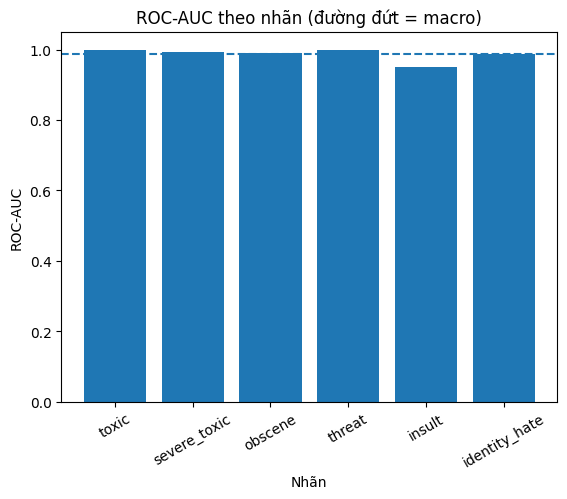

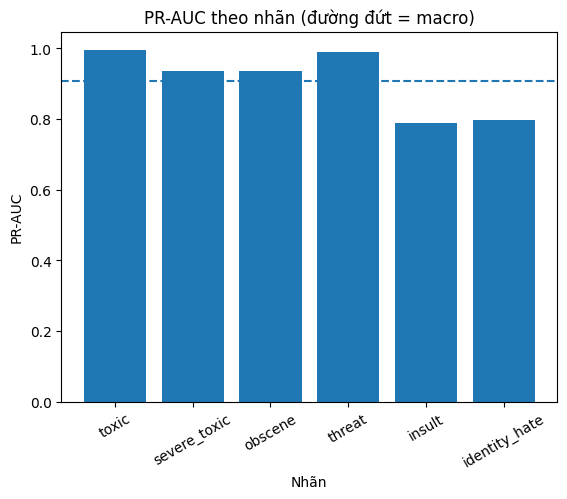

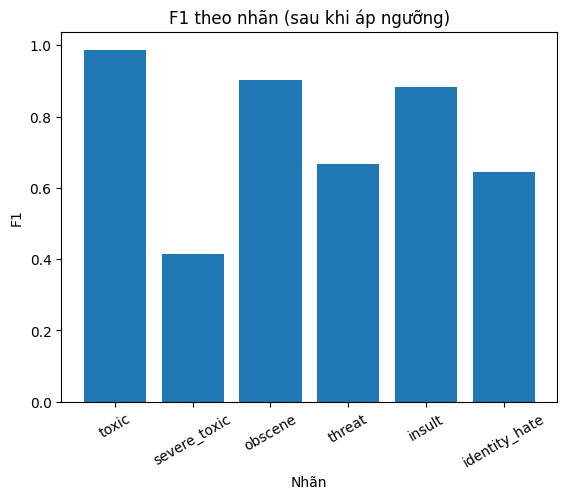

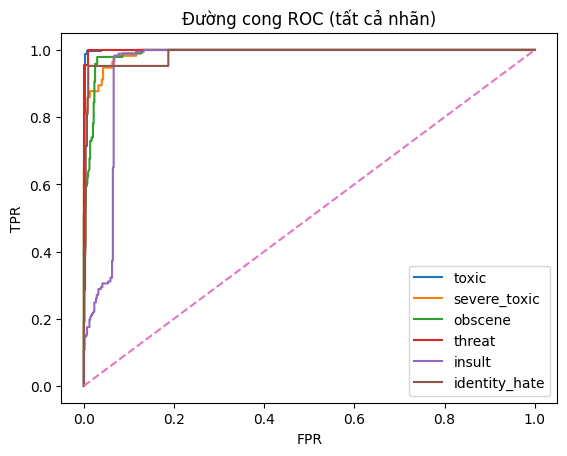

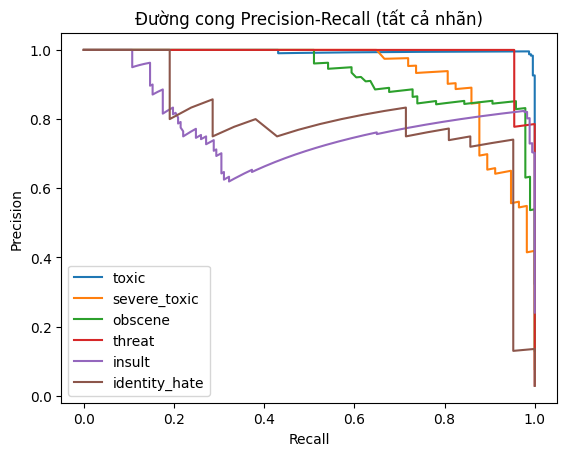

In [16]:
import os, numpy as np, pandas as pd, torch
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    classification_report, roc_curve, precision_recall_curve
)

def _pick_path(*candidates):
    for p in candidates:
        if isinstance(p, str) and os.path.exists(p):
            return p
    # nếu không có, trả về cái đầu để lỗi rõ ràng
    return candidates[0]

TEST_CSV  = _pick_path("test_vn.csv", "/content/drive/MyDrive/Colab Notebooks/dataset_toxic/test_vn.csv")
TL_CSV    = _pick_path("test_labels_vn.csv", "/content/drive/MyDrive/Colab Notebooks/dataset_toxic/test_labels_vn.csv")

def _resolve_thresholds(default: float = 0.5):
    thr_floor = float(globals().get("THR_FLOOR", 0.20))
    const_map = dict(globals().get("THRESHOLDS", {}))
    return {c: max(float(const_map.get(c, default)), thr_floor) for c in LABELS}

def _predict_batch(texts):
    # 1) Dùng predict_texts nếu có
    if "predict_texts" in globals():
        outs = predict_texts(texts)
        if isinstance(outs, (list, tuple)) and len(outs) and isinstance(outs[0], dict) and "probs" in outs[0]:
            probs = np.array([[o["probs"][c] for c in LABELS] for o in outs], dtype=float)
            return probs
        try:
            arr = np.array(outs, dtype=float)
            if arr.ndim == 2 and arr.shape[1] == len(LABELS):
                return arr
        except Exception:
            pass
    # 2) Fallback: tok + model
    assert "tok" in globals() and "model" in globals(), \
        "Không tìm thấy predict_texts() hoặc (tok, model). Hãy định nghĩa trước khi chạy."
    max_len = int(globals().get("MAX_LEN", 256))
    device  = globals().get("device", "cuda" if torch.cuda.is_available() else "cpu")
    batch = tok(texts, truncation=True, padding=True, max_length=max_len, return_tensors="pt").to(device)
    with torch.inference_mode():
        logits = model(**batch).logits
        probs = torch.sigmoid(logits).detach().cpu().numpy()
    assert probs.shape[1] == len(LABELS), f"Expect {len(LABELS)} labels, got {probs.shape[1]}"
    return probs

def run_inference(series_text, batch_size=128):
    preds = []
    for i in range(0, len(series_text), batch_size):
        chunk = series_text.iloc[i:i+batch_size].tolist()
        preds.append(_predict_batch(chunk))
    return np.vstack(preds) if preds else np.zeros((0, len(LABELS)))

# 2) Load
test = pd.read_csv(TEST_CSV)
y_true_full = pd.read_csv(TL_CSV).set_index("id")[LABELS]
# Ép kiểu nhãn đề phòng strings '0'/'1'
y_true_full = y_true_full.apply(pd.to_numeric, errors="coerce").fillna(-1).astype(int)

# 3) Predict
probs = run_inference(test["comment_text"])
yp = pd.DataFrame(probs, columns=LABELS, index=test["id"].values)

# 4) Bỏ hàng có -1
mask_scored = (y_true_full != -1).all(axis=1)
yt = y_true_full.loc[mask_scored]
yp = yp.loc[mask_scored]

# 5) Metrics dạng xếp hạng (ROC/PR)
per_label = []
for c in LABELS:
    try:
        auc = roc_auc_score(yt[c], yp[c])
    except ValueError:
        auc = float("nan")
    try:
        ap = average_precision_score(yt[c], yp[c])
    except ValueError:
        ap = float("nan")
    per_label.append({"label": c, "roc_auc": auc, "pr_auc": ap})

df_rank = pd.DataFrame(per_label)
macro_roc = float(np.nanmean(df_rank["roc_auc"].values))
macro_pr  = float(np.nanmean(df_rank["pr_auc"].values))

# 6) Metrics theo ngưỡng
thr_map = _resolve_thresholds(default=0.5)
yp_bin = pd.DataFrame({c: (yp[c].values >= thr_map[c]).astype(int) for c in LABELS}, index=yp.index)
# Ép kiểu chắc chắn
yt_int = yt.astype(int)
yp_int = yp_bin.astype(int)

f1_micro = f1_score(yt_int.values, yp_int.values, average="micro", zero_division=0)
f1_macro = f1_score(yt_int.values, yp_int.values, average="macro", zero_division=0)
f1_per_label = [{"label": c, "f1": f1_score(yt_int[c], yp_int[c], zero_division=0)} for c in LABELS]
df_f1 = pd.DataFrame(f1_per_label)

print("=== Tổng hợp (macro) ===")
print(f"Macro ROC-AUC: {macro_roc:.4f}")
print(f"Macro PR-AUC : {macro_pr:.4f}")
print(f"F1 micro(thr): {f1_micro:.4f}")
print(f"F1 macro(thr): {f1_macro:.4f}")

print("\n=== Classification report (per-label với ngưỡng) ===")
print("Ngưỡng:", {k: float(v) for k, v in thr_map.items()})
print(classification_report(yt_int.values, yp_int.values, target_names=LABELS, zero_division=0))

# 7) PLOTS — mỗi biểu đồ là 1 figure, không subplots, không set màu

# 7.1 ROC-AUC bar
plt.figure()
plt.bar(df_rank["label"], df_rank["roc_auc"])
plt.axhline(y=macro_roc, linestyle='--')
plt.title("ROC-AUC theo nhãn (đường đứt = macro)")
plt.xlabel("Nhãn"); plt.ylabel("ROC-AUC"); plt.xticks(rotation=30)
plt.show()

# 7.2 PR-AUC bar
plt.figure()
plt.bar(df_rank["label"], df_rank["pr_auc"])
plt.axhline(y=macro_pr, linestyle='--')
plt.title("PR-AUC theo nhãn (đường đứt = macro)")
plt.xlabel("Nhãn"); plt.ylabel("PR-AUC"); plt.xticks(rotation=30)
plt.show()

# 7.3 F1 per label bar
plt.figure()
plt.bar(df_f1["label"], df_f1["f1"])
plt.title("F1 theo nhãn (sau khi áp ngưỡng)")
plt.xlabel("Nhãn"); plt.ylabel("F1"); plt.xticks(rotation=30)
plt.show()

# 7.4 ROC curves (all labels)
plt.figure()
for c in LABELS:
    try:
        fpr, tpr, _ = roc_curve(yt_int[c], yp[c])
        plt.plot(fpr, tpr, label=c)
    except Exception:
        pass
plt.plot([0,1], [0,1], linestyle='--')
plt.title("Đường cong ROC (tất cả nhãn)")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()
plt.show()

# 7.5 PR curves (all labels)
plt.figure()
for c in LABELS:
    try:
        precision, recall, _ = precision_recall_curve(yt_int[c], yp[c])
        plt.plot(recall, precision, label=c)
    except Exception:
        pass
plt.title("Đường cong Precision-Recall (tất cả nhãn)")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()
plt.show()